# Classify ALS status using AFQ-Insight

In [1]:
import afqinsight as afqi
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import palettable
import pickle

from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d import Axes3D

from bokeh.io import output_notebook, reset_output, export_png
from bokeh.embed import file_html
from bokeh.layouts import row, column, widgetbox
from bokeh.models import BoxSelectTool, HoverTool, Legend, Title, Range1d, CustomJS, ColorBar
from bokeh.models.tickers import FixedTicker
from bokeh.models.mappers import LinearColorMapper
from bokeh.palettes import Spectral10, RdBu, Category10
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.resources import CDN
from bokeh.transform import factor_cmap
from bokeh.models import BoxAnnotation, Label

from sklearn.decomposition import PCA

%matplotlib notebook

In [2]:
output_notebook()

Loading BokehJS ...

## Load the data

In [3]:
afq_data = afqi.load_afq_data(
    '../data/raw/als_data',
    target_cols=['class'],
    binary_positives={'class': 'ALS'},
    scale_x=False
)

x, y, groups, columns, bias_index = (
    afq_data.x,
    afq_data.y['class'],
    afq_data.groups,
    afq_data.columns,
    afq_data.bias_index
)

/Users/richford/miniconda3/envs/insight-dev/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
len(y)

48

In [5]:
label_sets = afqi.multicol2sets(columns, tract_symmetry=True)
select_labels = [["fa"], ["md"]]
x_md_fa = afqi.select_groups(np.delete(x, bias_index, axis=1), select_labels, label_sets)

In [6]:
x_md_fa = np.hstack([x_md_fa, x[:, bias_index][:, np.newaxis]])

## Find the optimal feature coefficients $\widehat{\beta}$

We search for the optimal coefficients using two different classification scores: accuracy and ROC AUC.

In [7]:
# hp_cv_res_acc_new = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=5,
#     max_evals_per_cv=5,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/new_trials_for_poster',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [8]:
# hp_cv_res_acc_reload = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=5,
#     max_evals_per_cv=5,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/new_trials_for_poster',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [9]:
# hp_cv_res_acc_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=80,
#     score='accuracy',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_accuracy_md_fa_only',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [10]:
# hp_cv_res_auc = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='roc_auc',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_auc_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [11]:
# hp_cv_res_auc_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='roc_auc',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_auc_md_fa_only_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [12]:
# hp_cv_res_avgprec = afqi.fit_hyperparams_cv(
#     x, y, groups, bias_index=bias_index,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='avg_precision',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_avgprec_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [13]:
# hp_cv_res_avgprec_md_fa = afqi.fit_hyperparams_cv(
#     x_md_fa, y, groups[:40], bias_index=4000,
#     n_splits=10, n_repeats=3,
#     max_evals_per_cv=10,
#     score='avg_precision',
#     trials_pickle_dir='./trials_classification/cv3x10_v2_rs42_scaled_avgprec_md_fa_only_new',
#     verbose=1, random_state=42, clf_threshold=0.5
# )

In [14]:
# hp_cv_res_acc_new[0].keys()

In [15]:
# key = "trace"

# [np.allclose(r0[key].trace_fx, r1[key].trace_fx) for r0, r1 in zip(hp_cv_res_acc_new, hp_cv_res_acc_reload)]

In [16]:
# hp_cv_res_acc_new[0]["test"]

In [17]:
def print_results_summary(hp_cv_results):
    template = '{stat:15s} {mean:7.5g} ({var:7.5g})'
    test = [r["test"] for r in hp_cv_results]
    train = [r["train"] for r in hp_cv_results]
    test_acc = [t["accuracy"] for t in test]
    test_auc = [t["auc"] for t in test]
    test_aps = [t["avg_precision"] for t in test]
    train_acc = [t["accuracy"] for t in train]
    train_auc = [t["auc"] for t in train]
    train_aps = [t["avg_precision"] for t in train]

    print('Statistic         mean   (variance)')
    print('--------------  ------- ------------')
    print(template.format(stat='test accuracy', mean=np.mean(test_acc), var=np.var(test_acc)))
    print(template.format(stat='test AUC', mean=np.mean(test_auc), var=np.var(test_auc)))
    print(template.format(stat='test avg prec', mean=np.mean(test_aps), var=np.var(test_aps)))
    print(template.format(stat='train accuracy', mean=np.mean(train_acc), var=np.var(train_acc)))
    print(template.format(stat='train AUC', mean=np.mean(train_auc), var=np.var(train_auc)))
    print(template.format(stat='train avg prec', mean=np.mean(train_aps), var=np.var(train_aps)))

In [18]:
# print_results_summary(hp_cv_res_acc_new)

In [19]:
# print_results_summary(hp_cv_res_acc_reload)

In [20]:
# print_results_summary(hp_cv_res_acc)

In [21]:
# print_results_summary(hp_cv_res_acc_md_fa)

In [22]:
# print_results_summary(hp_cv_res_auc)

In [23]:
# print_results_summary(hp_cv_res_auc_md_fa)

In [24]:
# print_results_summary(hp_cv_res_avgprec)

In [25]:
# print_results_summary(hp_cv_res_avgprec_md_fa)

In [26]:
# hp_cv_res_acc_new[0]

In [27]:
# sgl = afqi.sgl_estimator(
#     hp_cv_res_acc_new[1]["train"]["x"],
#     hp_cv_res_acc_new[1]["train"]["y"],
#     hp_cv_res_acc_new[1]["test"]["x"],
#     hp_cv_res_acc_new[1]["test"]["y"],
#     groups,
#     alpha1=hp_cv_res_acc_new[1]["alpha1"],
#     alpha2=hp_cv_res_acc_new[1]["alpha2"],
#     eta=hp_cv_res_acc_new[1]["eta"],
#     transform_type=hp_cv_res_acc_new[1]["transform_type"],
#     loss_type="logloss",
#     clf_threshold=0.5
# )

In [28]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error

# Feature Importance

Let's sort the features by their importance

In [29]:
columns_md_fa = columns.drop(['ad', 'cl', 'curvature', 'rd', 'torsion', 'volume'], level=0)
columns_md_fa = columns_md_fa.remove_unused_levels()

In [30]:
subjects = pd.read_csv("../data/raw/als_data/subjects.csv")
nodes = pd.read_csv("../data/raw/als_data/nodes.csv")
merged = pd.merge(nodes, subjects, on="subjectID")
stats = nodes.columns.drop(["subjectID", "tractID", "nodeID"])
stat = merged[["nodeID", "tractID", "fa", "class"]]

In [33]:
tract_names = ["Right Corticospinal",]

In [34]:
false_pos_sub_ids = [
    "subject_030",
]

false_neg_sub_ids = [
    "subject_005",
    "subject_007",
]

false_pos_subs = {
    sid: merged[merged["subjectID"] == sid][["nodeID", "tractID", "fa", "class"]]
    for sid in false_pos_sub_ids
}

false_neg_subs = {
    sid: merged[merged["subjectID"] == sid][["nodeID", "tractID", "fa", "class"]]
    for sid in false_neg_sub_ids    
}

for sid in false_pos_subs.keys():
    false_pos_subs[sid] = false_pos_subs[sid][false_pos_subs[sid]["tractID"] == tract_names[0]]
    
for sid in false_neg_subs.keys():
    false_neg_subs[sid] = false_neg_subs[sid][false_neg_subs[sid]["tractID"] == tract_names[0]]

In [35]:
tract_stats = {}
for tid in tract_names:
    tract_stats[tid] = stat[stat["tractID"] == tid].drop("tractID", axis="columns")

In [36]:
import seaborn as sns

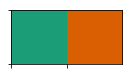

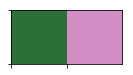

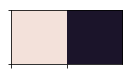

In [37]:
cat2 = ["#1b9e77","#d95f02"]
sub_cat2 = sns.color_palette("cubehelix", 2)

sns.palplot(sns.color_palette(cat2))
sns.palplot(sub_cat2)
sns.palplot(sns.cubehelix_palette(2, dark=0.1, light=0.9))

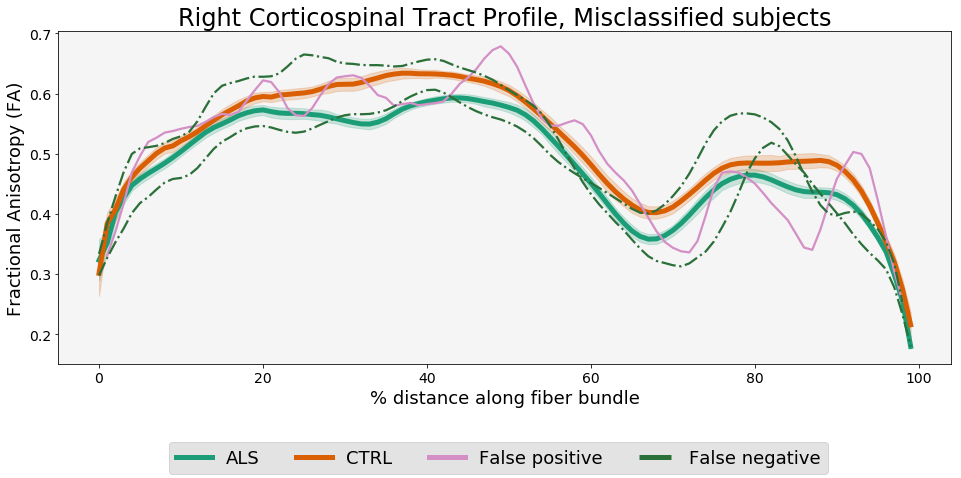

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
ticksize = 14
labelsize = 18
titlesize = 24
bgcolor = "whitesmoke"

df_stat = tract_stats[tract_names[0]]
title = tract_names[0]

sns.lineplot(
    x="nodeID", y="fa", hue="class", data=df_stat,
    ci=68.2, palette=cat2,
    ax=ax,
    linewidth=5.0
)

for sid, sub in false_pos_subs.items():
    _ = ax.plot(sub["nodeID"], sub["fa"],
                linewidth=2.25, linestyle="-",
                label="False positive", color=sub_cat2[1])

for sid, sub in false_neg_subs.items():
    _ = ax.plot(sub["nodeID"], sub["fa"],
                linewidth=2.25, linestyle="-.",
                label="False negative", color=sub_cat2[0])

_ = ax.set_ylabel("Fractional Anisotropy (FA)", fontsize=labelsize)
_ = ax.tick_params(axis='both', which='major', labelsize=ticksize)
_ = ax.set_facecolor(bgcolor)
_ = ax.get_legend().remove()

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

_ = ax.set_xlabel("% distance along fiber bundle", fontsize=labelsize)
_ = ax.set_title(tract_names[0] + " Tract Profile, Misclassified subjects", fontsize=titlesize)

handles, labels = ax.get_legend_handles_labels()

handles = handles[1:4] + [handles[-1]]
labels = labels[1:4] + [labels[-1]]

fig.subplots_adjust(bottom=0.22, wspace=0.3)

leg = plt.figlegend(
    handles, labels,
    fontsize=labelsize, facecolor="gainsboro",
    bbox_to_anchor=(0.4325, -0.01),
    loc="lower center",
    ncol=6
)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

fig.savefig("classification_subjects_profiles.pdf", bbox_inches="tight")